hid_orderings [0, 12, 4, 7, 14, 8, 10, 12, 12, 11, 12, 7, 4, 1, 3, 10, 0, 4, 14, 9, 0, 12, 10, 13, 12, 14, 7, 3, 12, 1, 8, 5, 1, 2, 0, 7, 12, 12, 11, 13, 3, 3, 4, 9, 10, 8, 0, 8, 6, 1, 4, 5, 14, 13, 8, 5, 4, 7, 11, 7, 2, 11, 2, 1] size 64
num hid layers: 1
expanded_input_ordering [0, 1, 1, 1, 2, 3] size 6
expanded_output_ordering [14, 14] size 2
hid_orderings [13, 2, 6, 22, 21, 25, 28, 30, 18, 28, 3, 9, 11, 23, 17, 9, 5, 14, 26, 1, 8, 12, 20, 16, 11, 2, 8, 2, 6, 16, 27, 29, 21, 14, 1, 8, 27, 16, 8, 5, 5, 24, 28, 14, 12, 0, 28, 12, 15, 30, 8, 22, 6, 4, 19, 21, 11, 26, 30, 26, 30, 1, 19, 19, 18, 28, 10, 5, 21, 28, 22, 7, 8, 16, 26, 27, 6, 28, 21, 23, 10, 22, 21, 23, 15, 1, 19, 3, 11, 4, 26, 29, 28, 2, 8, 3, 29, 11, 29, 19, 21, 19, 20, 6, 2, 3, 28, 20, 1, 13, 21, 15, 27, 1, 6, 4, 1, 21, 30, 16, 4, 3, 10, 16, 25, 7, 25, 10] size 128
num hid layers: 1
expanded_input_ordering [0, 0, 0, 1, 2, 3, 4] size 7
expanded_output_ordering [30, 30] size 2
hid_orderings [9, 4, 28, 26, 3, 8, 26, 23, 30, 

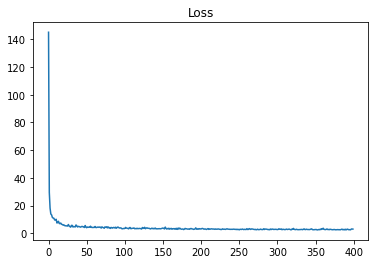

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal, AutoMultivariateNormal
from gmade import GMADE
random.seed(123)
torch.manual_seed(123)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)
        
class simpleRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, max_l=5, max_t=3):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size + max_l + max_t, hidden_size=hidden_size, nonlinearity='relu',
                          batch_first=True, num_layers=1)
        self.h_0 = nn.Parameter(torch.zeros((1, 1, hidden_size)))
        self.out_loc = nn.Linear(hidden_size, 1)
        self.out_std = nn.Linear(hidden_size, 1)
        self.max_l = max_l # max time steps
        self.max_t = max_t # type of random variables, ex. y1 y2 next_x
        self.softplus = nn.Softplus()
        
    def forward(self, x, obs, l, t):
        """
        x: x0
        obs: R
        l: length
        t: type, y1, y2 or next_x
        """
        length = l * 3
        input_x = x.repeat((int(length), 1))
        input_obs = obs.repeat((int(length), 1))
        input_l = []
        input_t = []
        
        for n in range(int(l)):
            
            for i in range(int(t)):
                input_l.append(n)
                input_t.append(i)
        input_l = F.one_hot(torch.tensor(input_l), self.max_l) 
        input_t = F.one_hot(torch.tensor(input_t), self.max_t) 
        
        input_ = torch.unsqueeze(torch.cat([input_x, input_obs, input_l, input_t], -1), 0)
        
        # the input is [x, obs, onehot(l), onehot(t)]
        rnn_output, _ = self.rnn(input_, self.h_0)
        rnn_output = torch.squeeze(rnn_output, 0)
        out_loc = self.out_loc(F.relu(rnn_output))
        out_std = self.softplus(self.out_std(F.relu(rnn_output)))
        # the first outputs are y_1_1, y_2_1, next_x_1; y_1_2, y_2_2, next_x_2
        return torch.squeeze(out_loc, 1), torch.squeeze(out_std, 1) # shape l * t

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 3
        
        # for guide_0
        self.x_y1_nn_0 = simpleNN(input_size= 3 + self.hidden_size)
        self.y1_y2_nn_0 = simpleNN(input_size=4 + self.hidden_size)
        self.y_x_nn_0 = simpleNN(input_size=4 + self.hidden_size)
        self.h_encoder_0 = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_0 = nn.Parameter(torch.zeros(self.hidden_size))
        
        # for guide_1
        self.x_y1_nn_1 = simpleNN(input_size= 2 + self.hidden_size)
        self.y1_y2_nn_1 = simpleNN(input_size=3 + self.hidden_size)
        self.y_x_nn_1 = simpleNN(input_size=3 + self.hidden_size)
        self.h_encoder_1 = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_1 = nn.Parameter(torch.zeros(self.hidden_size))
        
        # for guide_2
        self.x_y1_nn_2 = simpleNN(input_size= 2 + self.hidden_size)
        self.y1_y2_nn_2 = simpleNN(input_size=2 + self.hidden_size)
        self.y_x_nn_2 = simpleNN(input_size=2 + self.hidden_size)
        self.h_encoder_2 = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_2 = nn.Parameter(torch.zeros(self.hidden_size))
        
        # for guide_3
        self.x_y1_nn_3 = simpleNN(input_size= 1 + self.hidden_size)
        self.y1_y2_nn_3 = simpleNN(input_size=2 + self.hidden_size)
        self.y_x_nn_3 = simpleNN(input_size=2 + self.hidden_size)
        self.h_encoder_3 = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_3 = nn.Parameter(torch.zeros(self.hidden_size))
        
        # for guide_made_0
        self.hidden_size_made_0 = 2
        self.made_in_dim_0 = 1 + self.hidden_size_made_0
        self.num_var_0 = 3
        self.made_out_dim_0 = self.made_in_dim_0 * 2
        self.made_hidden_0 = [32, 32]
        self.made_0 = MADE(self.made_in_dim_0, self.made_hidden_0, self.made_out_dim_0, num_masks=1, natural_ordering=False)
        self.h_encoder_made_0 = simpleNN(input_size=1 + self.hidden_size_made_0, out_size=self.hidden_size_made_0, t="mlp")
        self.h0_made_0 = nn.Parameter(torch.zeros(self.hidden_size_made_0))
        
        
        # for guide_made_1
        self.hidden_size_made_1 = 3
        self.made_in_dim_1 = 3 + self.hidden_size_made_1
        self.num_var_1 = 3
        self.made_out_dim_1 = self.made_in_dim_1 * self.num_var_1
        self.made_hidden_1 = [32, 32]
        self.made_1 = MADE(self.made_in_dim_1, self.made_hidden_1, self.made_out_dim_1, num_masks=1, natural_ordering=True)
        self.made_out_loc_linear_1 = nn.ModuleList([nn.Linear(self.made_in_dim_1, 1) for _ in range(self.num_var_1)])
        self.made_out_std_linear_1 = nn.ModuleList([nn.Linear(self.made_in_dim_1, 1) for _ in range(self.num_var_1)])
        
        self.h_encoder_made_1 = simpleNN(input_size=1 + self.hidden_size_made_1, out_size=self.hidden_size_made_1, t="mlp")
        self.h0_made_1 = nn.Parameter(torch.zeros(self.hidden_size_made_1))
        
        # for guide_made_2
        self.hidden_size_made_2 = 3
        self.num_var_2 = 3
        self.made_in_dim_2 = self.num_var_2
        self.made_out_dim_2 = self.made_in_dim_2 * 2
        self.made_hidden_2 = [32, 32]
        self.made_2 = MADE(self.made_in_dim_2, self.made_hidden_2, self.made_out_dim_2, num_masks=1, natural_ordering=False)
        self.h_encoder_made_2 = simpleNN(input_size=1 + self.hidden_size_made_2, out_size=self.hidden_size_made_2, t="mlp")
        self.input_encoder_made_2 = simpleNN(input_size=3 + self.hidden_size_made_2, out_size=self.made_in_dim_2, t="mlp")
        self.h0_made_2 = nn.Parameter(torch.zeros(self.hidden_size_made_2))
        
        
        # for guide_made_3
        self.hidden_size_made_3 = 3
        self.made_in_dim_3 = 3 + self.hidden_size_made_3
        self.num_var_3 = 3
        self.made_out_dim_3 = self.made_in_dim_3 * self.num_var_3
        self.made_hidden_3 = [32, 32]
        self.made_3 = MADE(self.made_in_dim_3, self.made_hidden_3, self.made_out_dim_3, num_masks=1, natural_ordering=True)
        self.made_out_loc_linear_3 = nn.Linear(self.made_in_dim_3, 1) 
        self.made_out_std_linear_3 = nn.Linear(self.made_in_dim_3, 1)
        
        self.h_encoder_made_3 = simpleNN(input_size=1 + self.hidden_size_made_3, out_size=self.hidden_size_made_3, t="mlp")
        self.h0_made_3 = nn.Parameter(torch.zeros(self.hidden_size_made_3))
        
        
        self.softplus = nn.Softplus()
        
        
        # for guide_rnn
        self.simrnn = simpleRNN()
        
        
        # for guide_g_made
        input_dim_dict = {
            "r" : 1,
            "h" : 3,
            "obs_R": 1,
            "n" : 1
        }
        var_dim_dict = {
            "y_1" : 1,
            "y_2" : 1,
            "next_x" : 1
        }
        dependency_dict = {
            "y_1" : ["r", "h", "obs_R", "n"],
            "y_2" : ["y_1", "r", "h", "obs_R", "n"],
            "next_x" : ["y_2", "r", "h", "obs_R", "n"]
        }
        self.gmade = GMADE(input_dim_dict, dependency_dict, var_dim_dict)
        self.h_encoder_gmade = simpleNN(input_size=1 + self.hidden_size, out_size=self.hidden_size, t="mlp")
        self.h0_gmade = nn.Parameter(torch.zeros(self.hidden_size))
        
        
    def g(self, x):
        return torch.tanh(x) 
    
    # assume the model has two latent variables in each time step (note that groundtruth data gen has 3)
    # as we cannot build the perfect model in real life problems
    def model(self, x0, l, obs_R):
        pyro.module("model", self)
        def rec_model(x, n):
            r = self.g(x) # TODO change r to sample statement
            if n <= 0:
                return r
            else:
                y_1 = pyro.sample("y_1_{}".format(n), dist.Normal(x, 0.5))
             
                y_2 = pyro.sample("y_2_{}".format(n), dist.Normal(y_1, 0.5))
            
                next_x = pyro.sample("next_x_{}".format(n), dist.Normal(y_2, 0.5))
                return rec_model(next_x, n - 1) + r
    
        R = rec_model(x0, l)
    
        pyro.sample("obs_R", dist.Normal(R, 0.1), obs=obs_R)
        
    # guide uses simple and individual NN for each random variable, given obs_R for all random variables
    def guide_0(self, x0, l, obs_R):
        pyro.module("model", self)
        def rec_guide(x, n, h, obs_R):
            r = self.g(x)
            if n <= 0:
                return r
            else:
                y_1_loc, y_1_std = self.x_y1_nn_0([r, h, obs_R, n]) 
                y_1 = pyro.sample("y_1_{}".format(n), dist.Normal(y_1_loc, y_1_std))
                y_2_loc, y_2_std = self.y1_y2_nn_0([y_1, r, h, obs_R, n])
                y_2 = pyro.sample("y_2_{}".format(n), dist.Normal(y_2_loc, y_2_std))
                x_loc, x_std = self.y_x_nn_0([y_2, r, h, obs_R, n])
                next_x = pyro.sample("next_x_{}".format(n), dist.Normal(x_loc, x_std))
                
                h = self.h_encoder_0([h, r])
                return rec_guide(next_x, n - 1, h, obs_R) + r
    
        rec_guide(x0, l, self.h0_0, obs_R)
    
    # guide uses simple and individual NN for each random variable, given obs_R for all random variables
    def guide_gmade(self, x0, l, obs_R):
        pyro.module("model", self)
        def rec_guide(x, n, h, obs_R):
            r = self.g(x)
            if n <= 0:
                return r
            else:
                input_made = {
                    "r" : r,
                    "h" : h,
                    "obs_R" : obs_R,
                    "n" : n
                }
                output_dict = self.gmade(input_made, suffix="_{}".format(n))
                
                h = self.h_encoder_0([h, r])
                return rec_guide(output_dict["next_x"], n - 1, h, obs_R) + r
    
        rec_guide(x0, l, self.h0_0, obs_R)
    
    # guide uses simple and individual NN for each random variable, given obs_R for all random variables
    def guide_1(self, x0, l, obs_R):
        pyro.module("model", self)
        def rec_guide(x, n, h, obs_R):
            r = self.g(x)
            if n <= 0:
                return r
            else:
                y_1_loc, y_1_std = self.x_y1_nn_1([r, h, obs_R]) 
                y_1 = pyro.sample("y_1_{}".format(n), dist.Normal(y_1_loc, y_1_std))
                y_2_loc, y_2_std = self.y1_y2_nn_1([y_1, r, h, obs_R]) 
                y_2 = pyro.sample("y_2_{}".format(n), dist.Normal(y_2_loc, y_2_std))
                x_loc, x_std = self.y_x_nn_1([y_2, r, h, obs_R])
                next_x = pyro.sample("next_x_{}".format(n), dist.Normal(x_loc, x_std))
                
                h = self.h_encoder_1([h, r])
                return rec_guide(next_x, n - 1, h, obs_R) + r
    
        rec_guide(x0, l, self.h0_1, obs_R)
    
    # guide uses simple and individual NN for each random variable, given obs_R for y_1
    def guide_2(self, x0, l, obs_R):
        pyro.module("model", self)
        def rec_guide(x, n, h, obs_R):
            r = self.g(x)
            if n <= 0:
                return r
            else:
                y_1_loc, y_1_std = self.x_y1_nn_2([r, h, obs_R]) 
                y_1 = pyro.sample("y_1_{}".format(n), dist.Normal(y_1_loc, y_1_std))
                y_2_loc, y_2_std = self.y1_y2_nn_2([y_1, r, h]) 
                y_2 = pyro.sample("y_2_{}".format(n), dist.Normal(y_2_loc, y_2_std))
                x_loc, x_std = self.y_x_nn_2([y_2, r, h])
                next_x = pyro.sample("next_x_{}".format(n), dist.Normal(x_loc, x_std))
                
                h = self.h_encoder_2([h, r])
                return rec_guide(next_x, n - 1, h, obs_R) + r
    
        rec_guide(x0, l, self.h0_2, obs_R)
        
    # guide uses simple and individual NN for each random variable, no obs_R
    def guide_3(self, x0, l, obs_R):
        pyro.module("model", self)
        def rec_guide(x, n, h):
            r = self.g(x)
            if n <= 0:
                return r
            else:
                y_1_loc, y_1_std = self.x_y1_nn_3([r, h]) 
                y_1 = pyro.sample("y_1_{}".format(n), dist.Normal(y_1_loc, y_1_std))
                y_2_loc, y_2_std = self.y1_y2_nn_3([y_1, r, h])
                y_2 = pyro.sample("y_2_{}".format(n), dist.Normal(y_2_loc, y_2_std))
                x_loc, x_std = self.y_x_nn_3([y_2, r, h])
                next_x = pyro.sample("next_x_{}".format(n), dist.Normal(x_loc, x_std))
                
                h = self.h_encoder_3([h, r])
                return rec_guide(next_x, n - 1, h) + r
    
        rec_guide(x0, l, self.h0_3)
    
    # using made to replace all individual NNs, input h, r;
    # output[i] == ith random variable mean, output[i + input_dim] == ith random variable std
    def guide_made_0(self, x0, l, obs_R):
        pyro.module("model", self)
        def concat_input_made(x_list):
            for i in range(len(x_list)):
                if x_list[i].dim() == 0:
                    x_list[i] = torch.unsqueeze(x_list[i], dim=0)
            input_x = torch.cat(x_list)
            return input_x
        
        def rec_guide(x, n, h, obs_R):
            r = self.g(x)
            if n <= 0:
                return r
            else:
                var_names = ["y_1_{}".format(n), "y_2_{}".format(n), "next_x_{}".format(n)]
                input_x = concat_input_made([r, h])
                made_out = self.made_0(input_x)
                for i in range(self.num_var_0):
                    loc = made_out[i]
                    std = self.softplus(made_out[i + self.made_in_dim_0])
                    var = pyro.sample(var_names[i], dist.Normal(loc, std))
                
                h = self.h_encoder_made_0([h, r])
                return rec_guide(var, n - 1, h, obs_R) + r
    
        rec_guide(x0, l, self.h0_made_0, obs_R)
        
    # using made to replace all individual NNs, input r, h, obs_R, n, output dim input_dim * num_var(3)
    # use output mapping layers to output mean and std for ith random variable, particularly:
    # made_out[i * input_dim : (i+ 1) * input_dim] ===> mean, std ; each random var has its own output mapping layers
    def guide_made_1(self, x0, l, obs_R):
        pyro.module("model", self)
        def concat_input_made(x_list):
            for i in range(len(x_list)):
                if x_list[i].dim() == 0:
                    x_list[i] = torch.unsqueeze(x_list[i], dim=0)
            input_x = torch.cat(x_list)
            return input_x
        
        def rec_guide(x, n, h, obs_R):
            r = self.g(x)
            if n <= 0:
                return r
            else:
                var_names = ["y_1_{}".format(n), "y_2_{}".format(n), "next_x_{}".format(n)]
                input_x = concat_input_made([r, h, obs_R, n])
                made_out = self.made_1(input_x)
                for i in range(self.num_var_1):
                    hid = made_out[i * self.made_in_dim_1 : (i+1) * self.made_in_dim_1]
                    loc = self.made_out_loc_linear_1[i](hid)
                    std = self.softplus(self.made_out_std_linear_1[i](hid))
                    var = pyro.sample(var_names[i], dist.Normal(loc, std))
                
                h = self.h_encoder_made_1([h, r])
                return rec_guide(var, n - 1, h, obs_R) + r
    
        rec_guide(x0, l, self.h0_made_1, obs_R)
        
    # using made to replace all individual NNs, input r, h, obs_R, n;
    # map all inputs to n hidden states, where n == num_var in this basic block
    # output[i] == ith random variable mean, output[i + input_dim] == ith random variable std
    def guide_made_2(self, x0, l, obs_R):
        pyro.module("model", self)

        def rec_guide(x, n, h, obs_R):
            r = self.g(x)
            if n <= 0:
                return r
            else:
                var_names = ["y_1_{}".format(n), "y_2_{}".format(n), "next_x_{}".format(n)]
                input_x = self.input_encoder_made_2([r, h, obs_R, n])
                made_out = self.made_2(input_x)
                for i in range(self.num_var_2):
                    loc = made_out[i]
                    std = self.softplus(made_out[i + self.made_in_dim_2])
                    var = pyro.sample(var_names[i], dist.Normal(loc, std))
                
                h = self.h_encoder_made_2([h, r])
                return rec_guide(var, n - 1, h, obs_R) + r
    
        rec_guide(x0, l, self.h0_made_2, obs_R)

    # using made to replace all individual NNs, input r, h, obs_R, n, output dim input_dim * num_var(3)
    # use output mapping layers to output mean and std for ith random variable, particularly:
    # made_out[i * input_dim : (i+ 1) * input_dim] ===> mean, std ; random variables share output mapping layers
    def guide_made_3(self, x0, l, obs_R):
        pyro.module("model", self)
        def concat_input_made(x_list):
            for i in range(len(x_list)):
                if x_list[i].dim() == 0:
                    x_list[i] = torch.unsqueeze(x_list[i], dim=0)
            input_x = torch.cat(x_list)
            return input_x
        
        def rec_guide(x, n, h, obs_R):
            r = self.g(x)
            if n <= 0:
                return r
            else:
                var_names = ["y_1_{}".format(n), "y_2_{}".format(n), "next_x_{}".format(n)]
                input_x = concat_input_made([r, h, obs_R, n])
                made_out = self.made_3(input_x)
                for i in range(self.num_var_3):
                    hid = made_out[i * self.made_in_dim_3 : (i+1) * self.made_in_dim_3]
                    loc = self.made_out_loc_linear_3(hid)
                    std = self.softplus(self.made_out_std_linear_3(hid))
                    var = pyro.sample(var_names[i], dist.Normal(loc, std))
                
                h = self.h_encoder_made_3([h, r])
                return rec_guide(var, n - 1, h, obs_R) + r
    
        rec_guide(x0, l, self.h0_made_3, obs_R)
    
    # guide uses a RNN to estimate distributions of all random variables
    def guide_rnn(self, x0, l, obs_R):
        pyro.module("model", self)
        t = 3
        out_loc, out_std = self.simrnn(x0, obs_R, l, t)
        
        for i in range(int(l)):
            pyro.sample("y_1_{}".format(l - i), dist.Normal(out_loc[i * t], out_std[i * t])) # maybe i here?
            pyro.sample("y_2_{}".format(l - i), dist.Normal(out_loc[i * t + 1], out_std[i * t + 1])) # maybe i here?
            pyro.sample("next_x_{}".format(l - i), dist.Normal(out_loc[i * t + 2], out_std[i * t + 2])) # maybe i here?
        
def generate_data():
    # the actual data generation has three latent variables (y_1, y_2, y_3)
    x0 = torch.tensor(random.random())
    base_std = 0.6
    l = torch.tensor(random.randint(2, 5))
    R = 0
    x = x0
    for i in range(l):
        # standard deviation is decreasing
        std = base_std - i * 0.1
        R += torch.tanh(x)
        
        y_1 = dist.Normal(x, std).sample()
        # add some noise
        noise1 = random.random() / 5
        
        y_2 = dist.Normal(y_1 + noise1, std).sample()
        # add some noise
        noise2 = random.random() / 5
    
        y_3 = dist.Normal(y_2 + noise2, std).sample()
        # add some noise
        noise3 = random.random() / 5
        
        x = dist.Normal(y_3 + noise3, std).sample()
    return x0.float(), l.float(), R.float()

data = []
num_data = 100
for _ in range(num_data):
    data.append(generate_data())

experiment = Experiment()
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_gmade # guide_1

#guide = AutoNormal(experiment.model)
#guide = AutoMultivariateNormal(experiment.model)

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())


n_steps = 400
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    
    for x0, l, R in data:
        imme_loss += svi.step(x0, l, R) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

results:

In [2]:
# guide 0
[Step 10/200] Immediate Loss: 10.897096427083019 Accumlated Loss: 24.07399604648352
[Step 20/200] Immediate Loss: 6.586585423052311 Accumlated Loss: 8.56087434694171
[Step 30/200] Immediate Loss: 5.427656478881836 Accumlated Loss: 6.286525824904442
[Step 40/200] Immediate Loss: 5.76791431516409 Accumlated Loss: 5.656579471707344
[Step 50/200] Immediate Loss: 4.822795096933843 Accumlated Loss: 4.815895015358924
[Step 60/200] Immediate Loss: 4.40746598005295 Accumlated Loss: 4.366727933973074
[Step 70/200] Immediate Loss: 4.060884852707386 Accumlated Loss: 4.237406772494316
[Step 80/200] Immediate Loss: 3.2891077983379367 Accumlated Loss: 3.902767575621605
[Step 90/200] Immediate Loss: 3.7756632891297346 Accumlated Loss: 3.7543974510431286
[Step 100/200] Immediate Loss: 3.297055274844171 Accumlated Loss: 3.682017157822847
[Step 110/200] Immediate Loss: 3.399244492650032 Accumlated Loss: 3.419619444400072
[Step 120/200] Immediate Loss: 3.140221614539626 Accumlated Loss: 3.3451627815067773
[Step 130/200] Immediate Loss: 3.3548742634057995 Accumlated Loss: 3.2445356895625594
[Step 140/200] Immediate Loss: 3.097808829844 Accumlated Loss: 3.218830179899931
[Step 150/200] Immediate Loss: 2.974420528709889 Accumlated Loss: 3.0854880858659746
[Step 160/200] Immediate Loss: 3.027468394041062 Accumlated Loss: 3.081009613126516
[Step 170/200] Immediate Loss: 3.1476346796751016 Accumlated Loss: 2.9707428410947325
[Step 180/200] Immediate Loss: 3.1779525178670878 Accumlated Loss: 3.0013780316114427
[Step 190/200] Immediate Loss: 3.038894810378551 Accumlated Loss: 3.060519110441208
[Step 200/200] Immediate Loss: 2.84645428687334 Accumlated Loss: 2.885463625282049

SyntaxError: invalid syntax (<ipython-input-2-67798cbaab7d>, line 2)

In [ ]:
# guide_g_made
[Step 10/400] Immediate Loss: 10.093876553177838 Accumlated Loss: 28.116918125301602
[Step 20/400] Immediate Loss: 5.735325578451158 Accumlated Loss: 7.710717597097159
[Step 30/400] Immediate Loss: 4.141437416076659 Accumlated Loss: 5.249956729501486
[Step 40/400] Immediate Loss: 4.192413958907127 Accumlated Loss: 5.026298224061727
[Step 50/400] Immediate Loss: 4.032615008652211 Accumlated Loss: 4.37625692051649
[Step 60/400] Immediate Loss: 3.7924616149067867 Accumlated Loss: 4.056113148778677
[Step 70/400] Immediate Loss: 3.4080429872870455 Accumlated Loss: 3.938382657647133
[Step 80/400] Immediate Loss: 3.91588868767023 Accumlated Loss: 3.8055605174005023
[Step 90/400] Immediate Loss: 3.562930800914765 Accumlated Loss: 3.679675492316484
[Step 100/400] Immediate Loss: 3.166920450031757 Accumlated Loss: 3.4407147874832154
[Step 110/400] Immediate Loss: 3.3585270166397088 Accumlated Loss: 3.358105143129826
[Step 120/400] Immediate Loss: 3.4754280599951755 Accumlated Loss: 3.310290638148785
[Step 130/400] Immediate Loss: 3.7460891202092146 Accumlated Loss: 3.3028773609697817
[Step 140/400] Immediate Loss: 3.0938018533587455 Accumlated Loss: 3.2975916117429733
[Step 150/400] Immediate Loss: 3.1185010880231845 Accumlated Loss: 3.220666427582502
[Step 160/400] Immediate Loss: 3.303586041331289 Accumlated Loss: 3.1039333658218378
[Step 170/400] Immediate Loss: 2.8570777693390843 Accumlated Loss: 3.092048371642828
[Step 180/400] Immediate Loss: 3.1323183783888813 Accumlated Loss: 2.9743766522705553
[Step 190/400] Immediate Loss: 3.123101497292519 Accumlated Loss: 3.0700586830675602
[Step 200/400] Immediate Loss: 2.8325696131587033 Accumlated Loss: 3.0600864307284357
[Step 210/400] Immediate Loss: 3.203767530620098 Accumlated Loss: 2.957834710299969
[Step 220/400] Immediate Loss: 3.0082357767224295 Accumlated Loss: 2.8931357885897158
[Step 230/400] Immediate Loss: 2.871949333548545 Accumlated Loss: 2.8120275142788884
[Step 240/400] Immediate Loss: 2.770469197630882 Accumlated Loss: 2.7996084527373313
[Step 250/400] Immediate Loss: 2.776975691318512 Accumlated Loss: 2.781975454688072
[Step 260/400] Immediate Loss: 2.6096868035197263 Accumlated Loss: 2.736122457921505
[Step 270/400] Immediate Loss: 2.834006843566894 Accumlated Loss: 2.80602259850502
[Step 280/400] Immediate Loss: 2.7753792360425003 Accumlated Loss: 2.663630239576101
[Step 290/400] Immediate Loss: 2.6723285016417506 Accumlated Loss: 2.7857212778031823
[Step 300/400] Immediate Loss: 2.6797246611118317 Accumlated Loss: 2.7780214585959917
[Step 310/400] Immediate Loss: 2.743236700296403 Accumlated Loss: 2.8762407574951654
[Step 320/400] Immediate Loss: 2.9069129949808135 Accumlated Loss: 2.730512857496738
[Step 330/400] Immediate Loss: 2.5359984785318375 Accumlated Loss: 2.706855779349804
[Step 340/400] Immediate Loss: 2.8012781810760488 Accumlated Loss: 2.6973362797200684
[Step 350/400] Immediate Loss: 2.5512332478165627 Accumlated Loss: 2.7136866383254525
[Step 360/400] Immediate Loss: 2.987985840439795 Accumlated Loss: 2.7060461809039116
[Step 370/400] Immediate Loss: 2.8415988487005244 Accumlated Loss: 2.8244434046149256
[Step 380/400] Immediate Loss: 2.663631010353566 Accumlated Loss: 2.5774431353211398
[Step 390/400] Immediate Loss: 2.791434529423713 Accumlated Loss: 2.6088461354076866
[Step 400/400] Immediate Loss: 2.85814619064331 Accumlated Loss: 2.6991474525332446

In [ ]:
# guide 1
[Step 10/200] Immediate Loss: 7.559717512130738 Accumlated Loss: 18.33279416501522
[Step 20/200] Immediate Loss: 6.153506239354612 Accumlated Loss: 7.117524638921023
[Step 30/200] Immediate Loss: 5.541966640651227 Accumlated Loss: 5.684932113975287
[Step 40/200] Immediate Loss: 5.148693958520891 Accumlated Loss: 5.38080223414302
[Step 50/200] Immediate Loss: 4.858222780823709 Accumlated Loss: 5.372910097420216
[Step 60/200] Immediate Loss: 4.3179991856217415 Accumlated Loss: 5.156085780709981
[Step 70/200] Immediate Loss: 5.332767331004142 Accumlated Loss: 5.199428522855043
[Step 80/200] Immediate Loss: 4.723022387623786 Accumlated Loss: 4.88315895318985
[Step 90/200] Immediate Loss: 4.767818248569966 Accumlated Loss: 4.737200892984867
[Step 100/200] Immediate Loss: 4.6624362275004385 Accumlated Loss: 4.830253395944834
[Step 110/200] Immediate Loss: 4.3004247260093695 Accumlated Loss: 4.749406197190285
[Step 120/200] Immediate Loss: 4.410183604061603 Accumlated Loss: 4.58312035241723
[Step 130/200] Immediate Loss: 4.632457412481308 Accumlated Loss: 4.5502141160368925
[Step 140/200] Immediate Loss: 4.070656002163886 Accumlated Loss: 4.303979308575391
[Step 150/200] Immediate Loss: 4.219085508882999 Accumlated Loss: 4.468279556453227
[Step 160/200] Immediate Loss: 4.482489324808121 Accumlated Loss: 4.24668676546216
[Step 170/200] Immediate Loss: 4.571949941813946 Accumlated Loss: 4.236999658554792
[Step 180/200] Immediate Loss: 3.8510677894949903 Accumlated Loss: 4.2028233243823045
[Step 190/200] Immediate Loss: 4.390659238100055 Accumlated Loss: 4.3577096745073804
[Step 200/200] Immediate Loss: 3.561375828087331 Accumlated Loss: 4.068374880343676

In [ ]:
# guide 2
[Step 10/200] Immediate Loss: 36.34582948565483 Accumlated Loss: 102.13199270904065
[Step 20/200] Immediate Loss: 24.573131604790692 Accumlated Loss: 27.80764180260897
[Step 30/200] Immediate Loss: 22.30637564986943 Accumlated Loss: 23.54905093795061
[Step 40/200] Immediate Loss: 20.33765312969684 Accumlated Loss: 21.59236597812176
[Step 50/200] Immediate Loss: 19.630492952466017 Accumlated Loss: 20.015027120113373
[Step 60/200] Immediate Loss: 17.475191622376446 Accumlated Loss: 19.02552970287204
[Step 70/200] Immediate Loss: 18.147958450019356 Accumlated Loss: 17.944058370858432
[Step 80/200] Immediate Loss: 17.768492654562 Accumlated Loss: 17.357401265323166
[Step 90/200] Immediate Loss: 17.098091254830358 Accumlated Loss: 17.070186663359404
[Step 100/200] Immediate Loss: 16.87052688539028 Accumlated Loss: 17.304257960915567
[Step 110/200] Immediate Loss: 17.376896535158156 Accumlated Loss: 17.405616234004498
[Step 120/200] Immediate Loss: 15.72870985478163 Accumlated Loss: 16.184437985241416
[Step 130/200] Immediate Loss: 16.505062356293205 Accumlated Loss: 16.479880607217552
[Step 140/200] Immediate Loss: 14.654706366658216 Accumlated Loss: 16.586361252725123
[Step 150/200] Immediate Loss: 17.06694069772959 Accumlated Loss: 16.37410228174925
[Step 160/200] Immediate Loss: 16.8475823968649 Accumlated Loss: 16.51549323582649
[Step 170/200] Immediate Loss: 16.110470311045646 Accumlated Loss: 16.22321096855402
[Step 180/200] Immediate Loss: 18.03824138969183 Accumlated Loss: 16.213583804011346
[Step 190/200] Immediate Loss: 16.448858000338078 Accumlated Loss: 16.252151167631148
[Step 200/200] Immediate Loss: 16.104524869918823 Accumlated Loss: 16.338763901770115

In [ ]:
# guide 3
[Step 10/200] Immediate Loss: 129.39596097201107 Accumlated Loss: 150.33133329963687
[Step 20/200] Immediate Loss: 128.21112619131807 Accumlated Loss: 132.53726438537242
[Step 30/200] Immediate Loss: 117.83395487815142 Accumlated Loss: 120.01952632072569
[Step 40/200] Immediate Loss: 116.78343730509283 Accumlated Loss: 118.54713125389816
[Step 50/200] Immediate Loss: 116.25210932254794 Accumlated Loss: 115.84209503382444
[Step 60/200] Immediate Loss: 117.45410153686997 Accumlated Loss: 115.28587766537069
[Step 70/200] Immediate Loss: 112.48804287433627 Accumlated Loss: 116.32100198805334
[Step 80/200] Immediate Loss: 112.87405549257987 Accumlated Loss: 114.50239012616872
[Step 90/200] Immediate Loss: 112.65670664697886 Accumlated Loss: 113.1228032810688
[Step 100/200] Immediate Loss: 113.96976754337548 Accumlated Loss: 114.07826335078478
[Step 110/200] Immediate Loss: 119.35383942961693 Accumlated Loss: 113.20602866864202
[Step 120/200] Immediate Loss: 108.93617531657218 Accumlated Loss: 114.54492359772323
[Step 130/200] Immediate Loss: 111.59455785870557 Accumlated Loss: 113.15705430191757
[Step 140/200] Immediate Loss: 111.8253447008132 Accumlated Loss: 113.49238991543649
[Step 150/200] Immediate Loss: 115.3344919478893 Accumlated Loss: 111.89611885094641
[Step 160/200] Immediate Loss: 115.06518815487618 Accumlated Loss: 114.72096209207179
[Step 170/200] Immediate Loss: 111.97390507310628 Accumlated Loss: 113.52600042599438
[Step 180/200] Immediate Loss: 110.2163209789991 Accumlated Loss: 112.27746578404307
[Step 190/200] Immediate Loss: 112.16051963776347 Accumlated Loss: 113.08217988958955
[Step 200/200] Immediate Loss: 109.15450765848156 Accumlated Loss: 112.25836501994726

In [ ]:
# guide rnn
[Step 10/200] Immediate Loss: 9.640962693095211 Accumlated Loss: 30.67832644885778
[Step 20/200] Immediate Loss: 8.272537976801395 Accumlated Loss: 9.594280518233777
[Step 30/200] Immediate Loss: 8.173096621632574 Accumlated Loss: 8.33986207279563
[Step 40/200] Immediate Loss: 8.519405342340468 Accumlated Loss: 7.8515220711529246
[Step 50/200] Immediate Loss: 7.4075272080302215 Accumlated Loss: 7.428417345315219
[Step 60/200] Immediate Loss: 7.175404669940471 Accumlated Loss: 7.056655042648316
[Step 70/200] Immediate Loss: 6.88103425234556 Accumlated Loss: 7.183161941289901
[Step 80/200] Immediate Loss: 7.21724983394146 Accumlated Loss: 6.844631317824125
[Step 90/200] Immediate Loss: 6.871469007134438 Accumlated Loss: 7.018842077046632
[Step 100/200] Immediate Loss: 6.306239696443082 Accumlated Loss: 6.959406811505557
[Step 110/200] Immediate Loss: 7.416387225091456 Accumlated Loss: 6.738025695741176
[Step 120/200] Immediate Loss: 6.731718974411488 Accumlated Loss: 7.003545281022788
[Step 130/200] Immediate Loss: 6.534330331981184 Accumlated Loss: 6.728503110408784
[Step 140/200] Immediate Loss: 6.389326887428762 Accumlated Loss: 6.637771991342307
[Step 150/200] Immediate Loss: 6.565908052623272 Accumlated Loss: 6.575905843764544
[Step 160/200] Immediate Loss: 6.7690025347471225 Accumlated Loss: 6.682427942067384
[Step 170/200] Immediate Loss: 6.35611254155636 Accumlated Loss: 6.5264977272748945
[Step 180/200] Immediate Loss: 6.129716929793357 Accumlated Loss: 6.537472707509994
[Step 190/200] Immediate Loss: 6.21984536796808 Accumlated Loss: 6.584824181616307
[Step 200/200] Immediate Loss: 6.228714998960494 Accumlated Loss: 6.4946992860734465

In [ ]:
# guide made 0
[Step 10/200] Immediate Loss: 160.48423355847603 Accumlated Loss: 182.85270177999138
[Step 20/200] Immediate Loss: 136.2737018719316 Accumlated Loss: 149.25851898822188
[Step 30/200] Immediate Loss: 139.77632999777796 Accumlated Loss: 143.84995370826127
[Step 40/200] Immediate Loss: 133.49804007470604 Accumlated Loss: 139.32783275571464
[Step 50/200] Immediate Loss: 136.53222409278152 Accumlated Loss: 139.32025609317424
[Step 60/200] Immediate Loss: 141.1230897080898 Accumlated Loss: 136.13689444220066
[Step 70/200] Immediate Loss: 135.14042346447707 Accumlated Loss: 134.6072166762948
[Step 80/200] Immediate Loss: 140.2574947077036 Accumlated Loss: 134.44344882920382
[Step 90/200] Immediate Loss: 133.19639854818587 Accumlated Loss: 132.08353916981815
[Step 100/200] Immediate Loss: 125.4555533385277 Accumlated Loss: 130.69213940227033
[Step 110/200] Immediate Loss: 139.7100527447462 Accumlated Loss: 132.99286480870845
[Step 120/200] Immediate Loss: 132.32316820651295 Accumlated Loss: 134.52053939491512
[Step 130/200] Immediate Loss: 128.39376810431477 Accumlated Loss: 132.10056481549145
[Step 140/200] Immediate Loss: 129.62434692651033 Accumlated Loss: 132.78218272250888
[Step 150/200] Immediate Loss: 126.35322604447606 Accumlated Loss: 133.0661242879331
[Step 160/200] Immediate Loss: 134.50700048357257 Accumlated Loss: 132.68880042499308
[Step 170/200] Immediate Loss: 125.88842075854538 Accumlated Loss: 133.48948980358242
[Step 180/200] Immediate Loss: 128.79157200038426 Accumlated Loss: 131.80554548048974
[Step 190/200] Immediate Loss: 134.20808095455172 Accumlated Loss: 132.16203881713747
[Step 200/200] Immediate Loss: 129.1014901822805 Accumlated Loss: 131.55340434998274

In [ ]:
# guide made 1
NaturalOrdering=False
[Step 10/200] Immediate Loss: 14.019104228317742 Accumlated Loss: 53.64432947850229
[Step 20/200] Immediate Loss: 9.699863998293878 Accumlated Loss: 11.032929550886156
[Step 30/200] Immediate Loss: 7.148877637684345 Accumlated Loss: 8.264739600002766
[Step 40/200] Immediate Loss: 7.238150359988211 Accumlated Loss: 6.981379968196154
[Step 50/200] Immediate Loss: 6.0434359559416775 Accumlated Loss: 6.643292198151348
[Step 60/200] Immediate Loss: 6.070013944506647 Accumlated Loss: 6.357983798265456
[Step 70/200] Immediate Loss: 6.789834988117221 Accumlated Loss: 6.619088857740164
[Step 80/200] Immediate Loss: 6.323514266908169 Accumlated Loss: 6.1634104528427125
[Step 90/200] Immediate Loss: 6.665135125517846 Accumlated Loss: 6.185240255266428
[Step 100/200] Immediate Loss: 6.078257759213448 Accumlated Loss: 6.409523689031601
[Step 110/200] Immediate Loss: 6.695484466254712 Accumlated Loss: 6.648152809649706
[Step 120/200] Immediate Loss: 5.736008805036541 Accumlated Loss: 5.941689832746982
[Step 130/200] Immediate Loss: 6.426270787715911 Accumlated Loss: 5.963468790888786
[Step 140/200] Immediate Loss: 5.827706450521947 Accumlated Loss: 5.8566648783683775
[Step 150/200] Immediate Loss: 6.102512870728971 Accumlated Loss: 5.749399427473547
[Step 160/200] Immediate Loss: 6.727250106334686 Accumlated Loss: 5.821995285272598
[Step 170/200] Immediate Loss: 5.84557059943676 Accumlated Loss: 5.8491086800396435
[Step 180/200] Immediate Loss: 5.364269751608374 Accumlated Loss: 5.701569260686635
[Step 190/200] Immediate Loss: 6.074659641683102 Accumlated Loss: 5.867555259823797
[Step 200/200] Immediate Loss: 5.423869117200372 Accumlated Loss: 5.6179648361206045
        
NaturalOrdering=True
[Step 10/200] Immediate Loss: 16.073262527287007 Accumlated Loss: 100.58396736195684
[Step 20/200] Immediate Loss: 8.754549311697483 Accumlated Loss: 10.962106433063745
[Step 30/200] Immediate Loss: 7.634609906077385 Accumlated Loss: 8.177316520512104
[Step 40/200] Immediate Loss: 6.4821303054690365 Accumlated Loss: 6.937638696998359
[Step 50/200] Immediate Loss: 6.452378512024877 Accumlated Loss: 6.032111377894878
[Step 60/200] Immediate Loss: 5.6379613992571835 Accumlated Loss: 5.908414689779281
[Step 70/200] Immediate Loss: 5.733489564657215 Accumlated Loss: 5.464340224891902
[Step 80/200] Immediate Loss: 5.209848814010621 Accumlated Loss: 5.376727032631636
[Step 90/200] Immediate Loss: 5.956956093907354 Accumlated Loss: 5.560123661011456
[Step 100/200] Immediate Loss: 5.223151791691779 Accumlated Loss: 5.326080230921507
[Step 110/200] Immediate Loss: 4.814688653051852 Accumlated Loss: 5.205872291654348
[Step 120/200] Immediate Loss: 6.60426853686571 Accumlated Loss: 5.5602356737554075
[Step 130/200] Immediate Loss: 5.436120665967464 Accumlated Loss: 5.156234309822321
[Step 140/200] Immediate Loss: 4.893183960914612 Accumlated Loss: 5.31840815603733
[Step 150/200] Immediate Loss: 5.22995001167059 Accumlated Loss: 5.081223203510046
[Step 160/200] Immediate Loss: 5.380219370126723 Accumlated Loss: 5.248564005374908
[Step 170/200] Immediate Loss: 5.119603236019612 Accumlated Loss: 5.480683054149152
[Step 180/200] Immediate Loss: 4.46067540407181 Accumlated Loss: 5.032706862658262
[Step 190/200] Immediate Loss: 4.931696077585218 Accumlated Loss: 5.102018988072871
[Step 200/200] Immediate Loss: 5.070164603292943 Accumlated Loss: 5.01442726829648

In [ ]:
# guide made 2
[Step 10/200] Immediate Loss: 168.91788237839936 Accumlated Loss: 187.96732055580617
[Step 20/200] Immediate Loss: 150.52404758065938 Accumlated Loss: 156.19228604671358
[Step 30/200] Immediate Loss: 154.54525569885973 Accumlated Loss: 144.47615030825136
[Step 40/200] Immediate Loss: 156.36513914287093 Accumlated Loss: 139.19961321538688
[Step 50/200] Immediate Loss: 132.17285798609262 Accumlated Loss: 140.33948809969425
[Step 60/200] Immediate Loss: 132.14123793751 Accumlated Loss: 136.13094830822945
[Step 70/200] Immediate Loss: 133.3406092461944 Accumlated Loss: 137.81934999725223
[Step 80/200] Immediate Loss: 134.44997272610664 Accumlated Loss: 133.3638133395314
[Step 90/200] Immediate Loss: 132.55868464320898 Accumlated Loss: 134.1936486185789
[Step 100/200] Immediate Loss: 130.04643192917106 Accumlated Loss: 134.29819335079193
[Step 110/200] Immediate Loss: 143.4784502640367 Accumlated Loss: 135.69545271345973
[Step 120/200] Immediate Loss: 131.35292657703167 Accumlated Loss: 133.35868326303367
[Step 130/200] Immediate Loss: 127.99579790413381 Accumlated Loss: 133.96785312217474
[Step 140/200] Immediate Loss: 135.98382707864045 Accumlated Loss: 132.0557901872396
[Step 150/200] Immediate Loss: 135.17538750559083 Accumlated Loss: 134.44175980606673
[Step 160/200] Immediate Loss: 138.24288726031784 Accumlated Loss: 132.41555623677374
[Step 170/200] Immediate Loss: 129.82562937021257 Accumlated Loss: 134.04827706205845
[Step 180/200] Immediate Loss: 130.17766936391587 Accumlated Loss: 133.5063454965353
[Step 190/200] Immediate Loss: 132.20994168728592 Accumlated Loss: 130.9864975514114
[Step 200/200] Immediate Loss: 131.49415226608517 Accumlated Loss: 131.03741551262144


In [ ]:
# guide made 3
[Step 10/200] Immediate Loss: 13.010656988024715 Accumlated Loss: 99.06157932758333
[Step 20/200] Immediate Loss: 7.5046216446161305 Accumlated Loss: 10.03270694538951
[Step 30/200] Immediate Loss: 6.117533451020719 Accumlated Loss: 6.660886912047863
[Step 40/200] Immediate Loss: 6.316120563745499 Accumlated Loss: 5.829992985129356
[Step 50/200] Immediate Loss: 5.437958541512489 Accumlated Loss: 5.892800804883243
[Step 60/200] Immediate Loss: 5.355252393484118 Accumlated Loss: 5.788893213301898
[Step 70/200] Immediate Loss: 5.657892731130121 Accumlated Loss: 5.508381419748067
[Step 80/200] Immediate Loss: 5.633600185513498 Accumlated Loss: 5.513742947548628
[Step 90/200] Immediate Loss: 5.984356532394888 Accumlated Loss: 5.526806058973074
[Step 100/200] Immediate Loss: 5.155731140077111 Accumlated Loss: 5.439844154447316
[Step 110/200] Immediate Loss: 5.017589632570741 Accumlated Loss: 5.296441371321677
[Step 120/200] Immediate Loss: 5.336543061435223 Accumlated Loss: 5.129204294204713
[Step 130/200] Immediate Loss: 5.345724000930784 Accumlated Loss: 5.303808857530355
[Step 140/200] Immediate Loss: 5.036817224025729 Accumlated Loss: 5.107035076290369
[Step 150/200] Immediate Loss: 5.201788758933546 Accumlated Loss: 5.104901222437621
[Step 160/200] Immediate Loss: 4.345631600022315 Accumlated Loss: 5.151430988103152
[Step 170/200] Immediate Loss: 5.063906903862953 Accumlated Loss: 4.814677561849355
[Step 180/200] Immediate Loss: 4.657406595349311 Accumlated Loss: 4.85194604074955
[Step 190/200] Immediate Loss: 4.788816937506198 Accumlated Loss: 5.085158434122801
[Step 200/200] Immediate Loss: 4.795215706825257 Accumlated Loss: 5.116604125469922

In [ ]:
model = MADE(3, [32, 32], 7, True)
x = torch.rand(3)
model(x)